In [1]:
import torch


In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3050 Laptop GPU


In [1]:
#import libraries
import torch,torchvision,pdb,os
from torch import nn
from  torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import wandb

c:\face\face-image-generator--1\naathing\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#defining hyper parameters
batch_size=128
epochs=5000
wandb_active=1
critic_cycle=5
lr=0.0001
z_dim=200
mean_gen_loss=[]
mean_critic_loss=[]
curr_step=0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
show_step=35
save_step=35

In [3]:
def show_from_tensor(tensor,num=25,wandb_log=1,name=" "):
    img=tensor.detach().cpu()
    images=make_grid(img[:num],nrow=5).permute(1,2,0)
    if (wandb_log==1 and wandb_active==1):
        wandb.log({name:wandb.Image(images.numpy().clip(0,1))})
    
    plt.figure(figsize=(6,6))
    plt.imshow(images.clip(0,1))
    plt.show()

In [4]:
wandb.login(key="7b043259eca153894ca3a1f456f024961f4a979d")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\tejag\_netrc
wandb: Currently logged in as: gunateja951 (gunateja951-omni) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
experiment_name="face-image-generator"
wandb.init(
    project="test",
    group=experiment_name,
    config={
        "batch_size": batch_size,
        "epochs": epochs,
        "critic_cycle": critic_cycle,
        "lr": lr,
        "z_dim": z_dim,
        "mean_gen_loss": mean_gen_loss,
        "mean_critic_loss": mean_critic_loss,
        "curr_step": curr_step,
        "device": device,
        "show_step": show_step,
        "save_step": save_step
    }
)
config= wandb.config

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=200, i_dim=16):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.i_dim = i_dim
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, i_dim * 16, 4, 1, 0),  # 1x1 → 4x4
            nn.BatchNorm2d(i_dim * 16),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(i_dim * 16, i_dim * 8, 4, 2, 1),  # 4x4 → 8x8
            nn.BatchNorm2d(i_dim * 8),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(i_dim * 8, i_dim * 4, 4, 2, 1),  # 8x8 → 16x16
            nn.BatchNorm2d(i_dim * 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(i_dim * 4, i_dim * 2, 4, 2, 1),  # 16x16 → 32x32
            nn.BatchNorm2d(i_dim * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(i_dim * 2, i_dim, 4, 2, 1),  # 32x32 → 64x64
            nn.BatchNorm2d(i_dim),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(i_dim, 3, 4, 2, 1),  # 64x64 → 128x128
            nn.Tanh()
        )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

        
def get_noise(n_samples,z_dim,device):
    return torch.randn(n_samples,z_dim).to(device)

In [7]:
class Critic(nn.Module):
    def __init__(self,i_dim=16):
        super(Critic,self).__init__()
        self.i_dim=i_dim
        self.critic=nn.Sequential(
            nn.Conv2d(3,i_dim*2,4,2,1),
            nn.InstanceNorm2d(i_dim*2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(i_dim*2,i_dim*4,4,2,1),
            nn.InstanceNorm2d(i_dim*4),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(i_dim*4,i_dim*8,4,2,1),
            nn.InstanceNorm2d(i_dim*8),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(i_dim*8,i_dim*16,4,2,1),
            nn.InstanceNorm2d(i_dim*16),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(i_dim*16,1,4,1,0),
        )
    
    def forward(self,x):
        x=self.critic(x)
        return x.view(len(x),-1)

In [ ]:
import gdown
import os

file_id = '1rnrH6dDlgj8aRRxgGcznCGKlXAUiUAC5'
output_path = 'data/img_align_celeba.7z'

os.makedirs('data', exist_ok=True)

# Download your private Drive file
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)


In [23]:
import subprocess
import time

archive_path = r"C:\Users\tejag\OneDrive\Desktop\face\face-image-generator-\data\img_align_celeba.7z"
output_path = r"C:\Users\tejag\OneDrive\Desktop\face\face-image-generator-\data\img_align_celeba"

start = time.time()

subprocess.run([
    r"C:\Program Files\7-Zip\7z.exe",
    'x',
    archive_path,
    f'-o{output_path}',
    '-mmt=on'
])

print(f"Extraction completed in {time.time() - start:.2f} seconds")


Extraction completed in 487.50 seconds


Data set loaded sucessfully


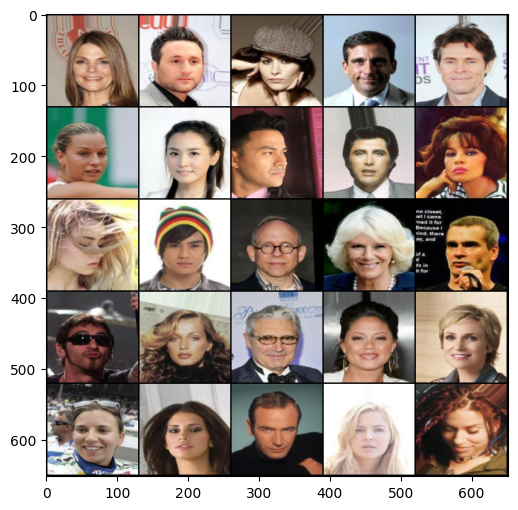

In [8]:
class dataset(Dataset):
    def __init__(self, path, lim=1000, size=128):
        self.path = path
        self.lim = lim
        self.size = [size, size]
        index, value = [], []
        for data in os.listdir(path)[:lim]:
            item = os.path.join(path, data)
            value.append(item)
            index.append(data)
        self.value = value
        self.index = index

    def __len__(self):
        return len(self.value)

    def __getitem__(self, idx):
        img = Image.open(self.value[idx])  # 177X155
        img = torchvision.transforms.Resize(self.size)(img)  # 128X128X3
        img = np.array(img).astype(np.float32) / 255.0  # Normalize to [0,1]
        img = np.transpose(img, (2, 0, 1))  # 3X128X128
        img = torch.from_numpy(img)
        return img, self.index[idx]
gen=Generator(z_dim).to(device)
cri=Critic().to(device)

#optimizers
gen_opt=torch.optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.9))
cri_opt=torch.optim.Adam(cri.parameters(),lr=lr,betas=(0.5,0.9))

data_path=r"C:\face\face-image-generator--1\data\img_align_celeba\img_align_celeba"
dataset=dataset(data_path,lim=1000,size=128)
dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=0)
print("Data set loaded sucessfully")
if wandb_active==1:
    wandb.watch(gen,log_freq=100)
    wandb.watch(cri,log_freq=100)
    
x,y=next(iter(dataloader))
show_from_tensor(x)

In [9]:
def gradent_penalty(real,fake,cri,alpha,beta=10):
    max_img=alpha*real+(1-alpha)*fake
    max_image_scores=cri(max_img)
    gradent=torch.autograd.grad(
        inputs=max_img,
        outputs=max_image_scores,
        grad_outputs=torch.ones_like(max_image_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradent=gradent.view(len(gradent),-1)
    gradent_norm= gradent.norm(2,dim=1)
    gp=beta * ((gradent_norm-1)**2).mean()
    return gp


In [10]:
#loading check points
root_dir=r"C:\face\face-image-generator--1\checkpoints\\"
def save_checkPoints(experiment_name='latest', epoch=0, curr_step=0):
    torch.save({
        'gen_state_dict': gen.state_dict(),
        'gen_opt_state_dict': gen_opt.state_dict(),
        'cri_state_dict': cri.state_dict(),
        'cri_opt_state_dict': cri_opt.state_dict(),
        'epoch': epoch,
        'curr_step': curr_step
    }, f"{root_dir}G-{experiment_name}.pkl")

    torch.save({
        'cri_state_dict': cri.state_dict(),
        'cri_opt_state_dict': cri_opt.state_dict(),
        'epoch': epoch,
        'curr_step': curr_step
    }, f"{root_dir}C-{experiment_name}.pkl")


def load_checkpoints(experiment_name='latest'):
    g_path = f"{root_dir}G-{experiment_name}.pkl"
    c_path = f"{root_dir}C-{experiment_name}.pkl"

    checkpoint_g = torch.load(g_path, map_location=device)
    gen.load_state_dict(checkpoint_g['gen_state_dict'])
    gen_opt.load_state_dict(checkpoint_g['gen_opt_state_dict'])

    checkpoint_c = torch.load(c_path, map_location=device)
    cri.load_state_dict(checkpoint_c['cri_state_dict'])
    cri_opt.load_state_dict(checkpoint_c['cri_opt_state_dict'])

    epoch = checkpoint_g.get('epoch', 0)
    curr_step = checkpoint_g.get('curr_step', 0)

    return epoch, curr_step

In [29]:
#for checking checkpoint functionality
# Correct root_dir definition
root_dir = r"C:\face\face-image-generator--1\checkpoints\\"

# Make sure directory exists
os.makedirs(root_dir, exist_ok=True)

# Test saving checkpoints with the actual models
print("Testing checkpoint save functionality...")
save_checkPoints("test")
print("Checkpoint test completed successfully!")

Testing checkpoint save functionality...
Checkpoint test completed successfully!


In [ ]:
try:
    start_epoch, curr_step = load_checkpoints('latest')
    print(f"Checkpoints loaded. Resuming from epoch {start_epoch}, step {curr_step}")
except FileNotFoundError:
    print("No 'latest' checkpoints found. Trying 'test' checkpoint...")
    try:
        start_epoch, curr_step = load_checkpoints('test')
        print(f"Test checkpoints loaded. Resuming from epoch {start_epoch}, step {curr_step}")
    except FileNotFoundError:
        print("No checkpoints found. Starting from scratch.")
        start_epoch = 0
        curr_step = 0
except Exception as e:
    print(f"Error loading checkpoint: {e}")
    start_epoch = 0
    curr_step = 0

✅ Checkpoints loaded. Resuming from epoch 3000, step 0


Checkpoints loaded. Resuming from epoch 1431, step 11480


  0%|          | 0/8 [00:00<?, ?it/s]

Saving checkpoint at step 11480


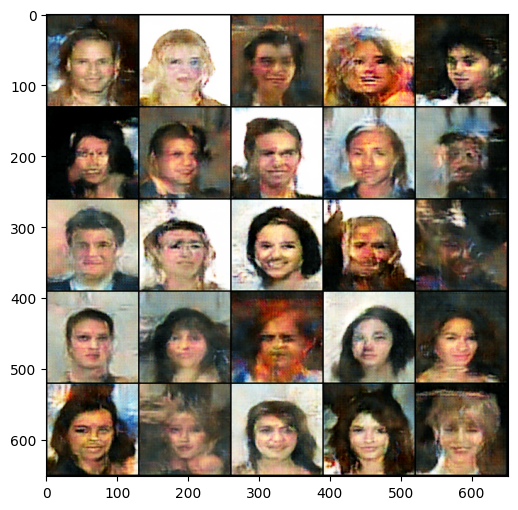

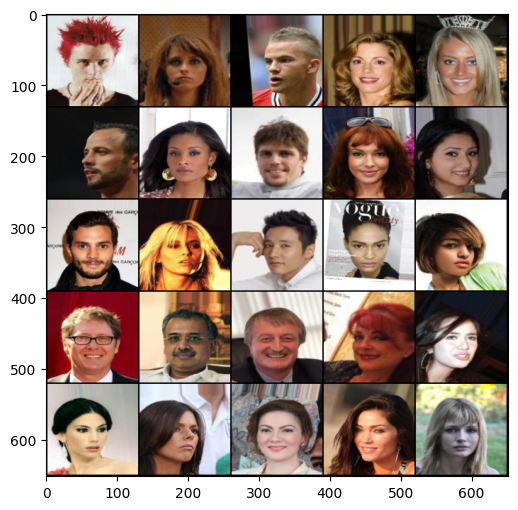

100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


Epoch checkpoint saved at epoch 1435


 38%|███▊      | 3/8 [00:04<00:07,  1.50s/it]

Saving checkpoint at step 11515


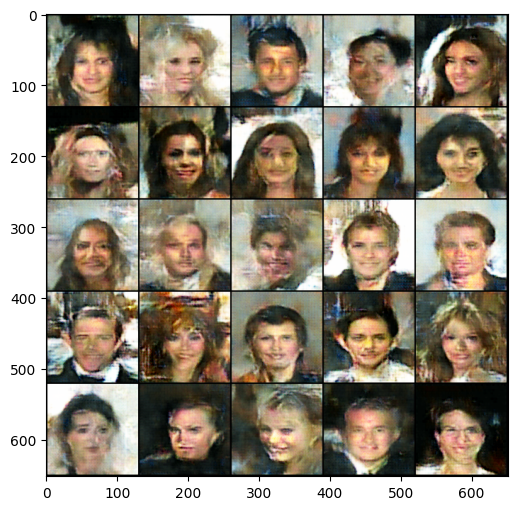

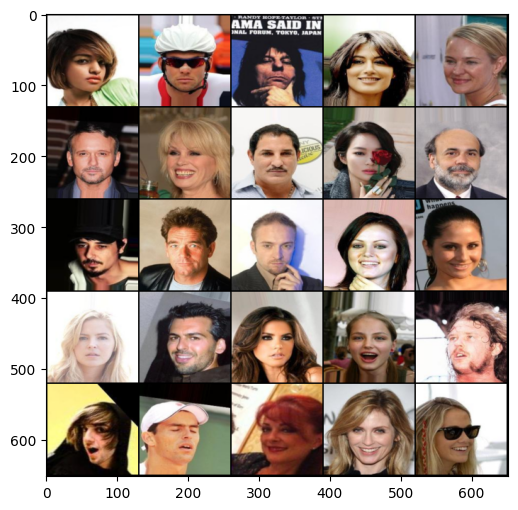

 25%|██▌       | 2/8 [00:04<00:13,  2.25s/it]


KeyboardInterrupt: 

In [ ]:
save_every = 5

for epoch in range(start_epoch, epochs):
    for real, _ in tqdm(dataloader):
        curr_batch = len(real)
        real = real.to(device)
        critic_losses = []

        mean_critic_loss = 0
        for _ in range(critic_cycle):
            cri_opt.zero_grad()
            noise = get_noise(curr_batch, z_dim, device)
            fake = gen(noise)

            critic_fake = cri(fake.detach())
            critic_real = cri(real)

            alpha = torch.rand(len(real), 1, 1, 1, requires_grad=True).to(device)
            gp = gradent_penalty(real, fake.detach(), cri, alpha)

            critic_loss = critic_fake.mean() - critic_real.mean() + gp
            mean_critic_loss += critic_loss.item() / critic_cycle

            critic_loss.backward() 
            cri_opt.step()

        critic_losses.append(mean_critic_loss)

        # === Generator ===
        gen_opt.zero_grad()
        noise = get_noise(curr_batch, z_dim, device)
        fake = gen(noise)
        critic_pred = cri(fake)
        gen_loss = -critic_pred.mean()
        gen_loss.backward()
        gen_opt.step()

        # === Stats ===
        if wandb_active == 1:
            wandb.log({
                'epoch': epoch,
                'Generator loss': gen_loss.item(),
                'Critic loss': mean_critic_loss
            })

        # === Periodic Save & Visualize ===
        if curr_step % show_step == 0 and curr_step > 0:
            print(f"Saving checkpoint at step {curr_step}")
            save_checkPoints('latest', epoch, curr_step)
            show_from_tensor(fake, wandb_log=1, name='fake')
            show_from_tensor(real, wandb_log=1, name='real')

        curr_step += 1

    # === Also save by epoch ===
    if (epoch + 1) % save_every == 0:
        save_checkPoints('latest', epoch, curr_step)
        print(f"Epoch checkpoint saved at epoch {epoch + 1}")

In [23]:
torch.cuda.empty_cache()


In [12]:
# Save generator
torch.save(gen.state_dict(), 'generator.pth')
